# Detección de displasia del desarrollo de cadera por radiografía pélvica: **Con aumento de datos.**

En el presente proyecto se busca hacer una clasificación binaria corresponde a la existencia o no de displasia de cadera en radiografías, usando para éstos redes neuronales convolucionales.

# Carga de datos 📂

Comenzamos con la preparación de nuestro datos, que en nuestro caso representa cargar correctamente las imagenes y darles la preparación adecuada o preprocesamiento para el entrenamiento de los diferentes modelos de machine Learning. Antes que todo, hay que importar las paqueterías necesaria y en nuestro caso, importar el drive puesto que ahí están nuestros datos ya cargados. En DRIVE, hay varias carpetas que corresponden a las dimensiones de las imagenes, usaremos nosotros las de 224 donde las imagenes están separadas en directorios con la clase a la que pertencen.

###Importamos librerías y montamos el DRIVE

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
import os
import matplotlib.image as mpimg
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import densenet
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K
from keras import layers
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import Flatten, BatchNormalization, Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50

from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


#Cargamos el DRIVE
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Para verificar que se cargó correctamente el DRIVE, definimos una función que toma de una dirección (la de nuestra carpeta cargada) una imagen aleatoria y la imprime en pantalla.

In [ ]:
def view_random_image(target_dir, target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+"/"+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder),1)
  #print(random_image)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  #print(f"Image shape: {img.shape}")
  return img

Mandamos llamar a nuestra anterior función y le pasamos la dirección a donde están nuestras imagenes, en particular a los de entrenamiento y además necesita de entrada el nombre de la carpeta donde necesita obtener las imagenes, así que tomaremos una de nuestras dos clases, en particular la llamada 'normal'.

In [ ]:
view_random_image("Path a dataset of DDH x-ray images 224","Normal")

Nos encargamos ademas de obtener de las carpetas de nuestro dataset correspondiente a las clases de nuestros datos.

In [ ]:
# Get the classnames programmatically
import pathlib
import numpy as np
data_dir = pathlib.Path("Path a dataset of DDH x-ray images 224")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
#class_names = class_names[1:] #remove .DS_store
num_classes = len(class_names)
print(class_names)

['DDH' 'Normal']


## Extracción de datos para entrenamiento y validación 🌐

Nos encargamos ahora de extraer los datos de nuestras carpetas para el entrenamiento de los modelos, sin embargo, por practicidad usaremos la librería ImageDatagenerator para llamar a una instancia de dicha librería y que sea ésta la que se use en entrenamiento y validación. De esta forma se evitan errores que podrían aparecer si cargamos directamente las imagenes en keras o tensorflow. Nos quedamos al final con dos instancias, train data y valid data, definimos la transformación de las dimensiones de las imagenes a 224x224.

En nuestro caso tenemos imagenes en blanco y negro y solo tenemos dos clases, así que específicamos el class_mode a binary. Especificamos ademas que son a blanco y negro, por eso ponemos el 'grayscale'.

Al no tener los datos separados de antemano, hacemos que se tengan instancias con subsets, de entrenamiento y validación.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path de los datos del DRIVE
data_dir = "Path a dataset of DDH x-ray images 224 Aumentado"
#data_dir = "/content/drive/MyDrive/COLAB/RICARDO - CADERA/Dataset/A dataset of DDH x-ray images/224"

# Parámetros de las imágenes
val_split = 0.2
batchsize = 32
seed = 42
img_dim = (224, 224, 1)  # Change to (224, 224, 1) for grayscale images

# Crea un objeto ImageDataGenerator para el conjunto de entrenamiento
Main_datagen = ImageDataGenerator(rescale=1./255, validation_split=val_split)  # rescale to [0, 1]

# Crea un generador de datos para el conjunto de entrenamiento
train_data = Main_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batchsize,
    class_mode='binary',
    color_mode='grayscale',  # Set color_mode to grayscale
    shuffle=True,
    seed=seed,
    subset='training'
)

# Crea un generador de datos para el conjunto de validación
valid_data = Main_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batchsize,
    class_mode='binary',
    color_mode='grayscale',  # Set color_mode to grayscale
    seed=seed,
    subset='validation'
)


Found 1884 images belonging to 2 classes.
Found 470 images belonging to 2 classes.


# Modelos de entrenamiento 📈

Los modelos de entrenamiento que usaremos serán directamente de deep learning, redes neuronales convolucionales. El objetivo consiste en clasificar correctamente nuestras dos clases, por lo que haremos una comparación entre el rendimiento de diferentes arquitecturas o modelos usando el dataset original. Usaremos primero una red neuronal convolucional "sencilla" con una implementación propia, para ver el comportamiento en el entrenamiento, posteriormente se usará una màs compleja y bien conocida con ResNet50. Una vez probados los modelos de deep learning, haremos prueba ahora con algoritmos clásicos de ML, como la máquina de soporte vectorial y un arbol de decisión.

##Construcción de los modelos de Deep Learning 🧠

nos encargamos ahora de construir y entrenar cada uno de los modelos mencionados anteriormente. Se usarán de entrada como metricas el accuracy y la función de perdida. Todas se entrenarán con 500 epocas.

Definimos ademas el input shape para los modelos.

### *CNN Genérica*

Red neuronal convolucional construida de cero, implementación propia desde tensorflow usando keras.



In [ ]:
tf.random.set_seed(42)

#  Create CNN
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(40, 3, activation='relu', input_shape=(224, 224, 1)),
  tf.keras.layers.MaxPool2D(pool_size=2), # reduce number of features by half
  tf.keras.layers.Conv2D(40, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(40, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation='sigmoid')

])

#  Compile our model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data, epochs=100, steps_per_epoch=len(train_data), validation_data=valid_data, validation_steps=len(valid_data))

Epoch 1/100
59/59 [==============================] - 532s 9s/step - loss: 0.1728 - accuracy: 0.9135 - val_loss: 2.2183 - val_accuracy: 0.7319
Epoch 2/100
59/59 [==============================] - 10s 172ms/step - loss: 0.0060 - accuracy: 0.9973 - val_loss: 0.7231 - val_accuracy: 0.7979
Epoch 3/100
59/59 [==============================] - 10s 169ms/step - loss: 1.6956e-04 - accuracy: 1.0000 - val_loss: 0.5915 - val_accuracy: 0.8149
Epoch 4/100
59/59 [==============================] - 9s 154ms/step - loss: 7.2967e-05 - accuracy: 1.0000 - val_loss: 0.6674 - val_accuracy: 0.8128
Epoch 5/100
59/59 [==============================] - 10s 172ms/step - loss: 3.6771e-05 - accuracy: 1.0000 - val_loss: 0.7577 - val_accuracy: 0.8085
Epoch 6/100
59/59 [==============================] - 11s 194ms/step - loss: 2.4814e-05 - accuracy: 1.0000 - val_loss: 0.7986 - val_accuracy: 0.8106
Epoch 7/100
59/59 [==============================] - 10s 176ms/step - loss: 1.9257e-05 - accuracy: 1.0000 - val_loss: 0.801

###*ResNet50*

Antes de entrenar el modelo, redefinimos nuestros sets de datos de entrenamiento, en el pasado se uso un canal de grises para las imagenes, ResNet50 requiere un fromato de 3 canales, por lo cual hay que hacer esa redefinición.

In [ ]:
# Path de los datos del DRIVE
data_dir = "Path a dataset of DDH x-ray images 224 Aumentado"

# Parámetros de las imágenes
val_split = 0.2
batchsize = 16
seed = 42
img_dim = (224, 224, 3)  # Change to (224, 224, 3)

# Crea un objeto ImageDataGenerator para el conjunto de entrenamiento
Main_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,  # Rescale to [0, 1]
    validation_split=val_split
)

# Crea un generador de datos para el conjunto de entrenamiento
train_data = Main_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batchsize,
    class_mode='binary',
    shuffle=True,
    seed=seed,
    subset='training'
)

# Crea un generador de datos para el conjunto de validación
valid_data = Main_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batchsize,
    class_mode='binary',
    seed=seed,
    subset='validation'
)

Found 1884 images belonging to 2 classes.
Found 470 images belonging to 2 classes.


Ahora si, procedemos a construir nuestro modelo ResNet50

In [ ]:
modelRes0 = Sequential()

modelRes0.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
modelRes0.add(Flatten())
modelRes0.add(BatchNormalization())
modelRes0.add(Dense(2048, activation='relu'))
modelRes0.add(BatchNormalization())
modelRes0.add(Dense(1024, activation='relu'))
modelRes0.add(BatchNormalization())
modelRes0.add(Dense(1, activation='sigmoid'))

modelRes0.layers[0].trainable = False
modelRes0.summary()

modelRes_sin_aum = modelRes0
modelRes_sin_aum = modelRes0

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 2048)              4196352   
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                       

compilamos el modelo

In [ ]:
# Compilar y entrenar el modelo
modelRes_sin_aum.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Hacemos el entrenamiento

In [ ]:
history = modelRes_sin_aum.fit(train_data, epochs=500, steps_per_epoch=len(train_data), validation_data=valid_data, validation_steps=len(valid_data))

Epoch 1/500
118/118 [==============================] - 24s 141ms/step - loss: 0.0544 - accuracy: 0.9851 - val_loss: 2.6361 - val_accuracy: 0.5234
Epoch 2/500
118/118 [==============================] - 12s 105ms/step - loss: 0.0332 - accuracy: 0.9931 - val_loss: 1.4407 - val_accuracy: 0.5234
Epoch 3/500
118/118 [==============================] - 12s 103ms/step - loss: 0.0108 - accuracy: 0.9979 - val_loss: 1.1474 - val_accuracy: 0.5447
Epoch 4/500
118/118 [==============================] - 12s 104ms/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.9419 - val_accuracy: 0.5617
Epoch 5/500
118/118 [==============================] - 12s 104ms/step - loss: 7.9873e-04 - accuracy: 1.0000 - val_loss: 1.2099 - val_accuracy: 0.6170
Epoch 6/500
118/118 [==============================] - 12s 104ms/step - loss: 0.0165 - accuracy: 0.9963 - val_loss: 2.3581 - val_accuracy: 0.5915
Epoch 7/500
118/118 [==============================] - 12s 101ms/step - loss: 0.0042 - accuracy: 0.9984 - val_loss: 2.28

## Construcción de los modelos Clasicos de ML ⛏

Nos encargamos ahora de construir y entrenar cada uno de los modelos de ML clasicos: La maquina de soporte vectorial y el arbol de decisión. Para hacer esto tenemos que hacer un preprocesamiento de los datos para poder ser leidos por dichos algoritmos.

### Preprocesamiento de los datos

Llamamos de la misma forma a image datagenerator, esto por si no se gusta correr lo anterior y solo correr esta parte de la libreta.

In [ ]:
# Path de los datos del DRIVE
data_dir = "Path a dataset of DDH x-ray images 224 Aumentado"

# Parámetros de las imágenes
val_split = 0.2
batchsize = 32
seed = 42
img_dim = (224, 224, 1)  # Change to (224, 224, 1) for grayscale images

# Crea un objeto ImageDataGenerator para el conjunto de entrenamiento
Main_datagen = ImageDataGenerator(rescale=1./255, validation_split=val_split)  # rescale to [0, 1]

# Crea generadores de datos para el conjunto de entrenamiento y validación
train_data = Main_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batchsize,
    class_mode='binary',
    color_mode='grayscale',  # Set color_mode to grayscale
    shuffle=True,
    seed=seed,
    subset='training'
)

valid_data = Main_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batchsize,
    class_mode='binary',
    color_mode='grayscale',  # Set color_mode to grayscale
    seed=seed,
    subset='validation'
)

Found 1884 images belonging to 2 classes.
Found 470 images belonging to 2 classes.


Definimos nuevas listas que serán las que tendran los datos de entrenamiento y validación con los ajustes necesarios para nuestros modelos

In [ ]:
# Procesamiento y transformación de las imágenes en características para SVM y Decision Tree

#Definimos listas nuevas para entrenamiento y valdiacion
X_train = []
y_train = []
X_valid = []
y_valid = []

#Recorremos train data, recuperando los batch y transformandolos en cada iteración
#Asignamos las dimensiones correctas y tipo por clase
for data_batch, labels_batch in train_data:
    features_batch = np.array(data_batch).reshape(len(data_batch), -1)
    X_train.extend(features_batch)
    y_train.extend(labels_batch)
    if len(X_train) >= len(train_data.classes):
        break

#Hacemos lo mismo para los datos de validación
for data_batch, labels_batch in valid_data:
    features_batch = np.array(data_batch).reshape(len(data_batch), -1)
    X_valid.extend(features_batch)
    y_valid.extend(labels_batch)
    if len(X_valid) >= len(valid_data.classes):
        break


### *SVM (Maquina de soporte vectorial)*

Construimos nuestra maquina de soporte vectorial usando ya los datos de entrenamiento y validación de nuestras nuevas listas

In [ ]:
# Entrenar SVM
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(X_train, y_train)
svm_pred_train = svm_classifier.predict(X_train)
svm_pred_valid = svm_classifier.predict(X_valid)

### Decision tree

In [ ]:
# Entrenar Árbol de DecisioN
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)
dt_pred_train = dt_classifier.predict(X_train)
dt_pred_valid = dt_classifier.predict(X_valid)

# Evaluación de los modelos de deep learning 📊

Una vez entrenado hacemos una predicción con nuestros valores de prueba para obtener la precisión de nuestro modelo y con la función Visualize_Result, vemos las graficas del accuracy en entrenamiento y validación a lo largo de las epocas. Esto nos permite ver la evolución ene el rendimiento del modelo a medida que se entrena la red neuronal, lo ideal es tener un comportamiento similar en ambas curvas asintótico a 1. Por otra parte, se pueden calcular los valores de la función de perdida de igual forma sobre las epocas, tanto en entrenamiento como en validación, donde lo esperado es un caracter asintótico similar entre ellas pero hacia 0.

Este proceso de hacer una predicción y mostrar las graficas de accuracy y loss, se hará con cada modelo, procederemos a explicarlo primero para la red CNN genérica, en los demás modelos seguiremos el mismo proceso.

Definimos primero la función que mandaremos llamar para hacer las graficas ya mencionadas, parte de los valroes de accuracy y los obtenidos en las variables history donde se guardan los valores de entrenamiento.

In [ ]:
#GRAFICAS DE ACCURACY Y LOSS
def Visualize_Result(acc,val_acc,loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(nrows = 1,
                                   ncols = 2,
                                   figsize = (15,6),
                                   sharex =True)

    plot1 = ax1.plot(range(0, len(acc)),
                     acc,
                     label = 'accuracy')

    plot2 = ax1.plot(range(0, len(val_acc)),
                     val_acc,
                     label = 'val_accuracy')

    ax1.set(title = 'Accuracy And Val Accuracy progress',
            xlabel = 'epoch',
            ylabel = 'accuracy/ validation accuracy')

    ax1.legend()

    plot3 = ax2.plot(range(0, len(loss)),
                     loss,
                     label = 'loss')

    plot4 = ax2.plot(range(0, len(val_loss)),
                     val_loss,
                     label = 'val_loss')

    ax2.set(title = 'Loss And Val loss progress',
            xlabel = 'epoch',
            ylabel = 'loss/ validation loss')

    ax2.legend()

    fig.suptitle('Result Of Model', fontsize = 20, fontweight = 'bold')
    fig.savefig('Accuracy_Loss_figure.png')
    plt.tight_layout()
    plt.show()

### CNN Genérica

Procedemos a evaluar la predicción imprimiendo la precisón del modelo respecto a datos de prueba no considerados en el entrenaniemto, imprimimos ademas el valor de la función de perdida.

Evaluamos una predicción

In [ ]:
#EVALUACIÓN DEL MODELO

loss_value , accuracy = model_1.evaluate(valid_data)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

#print(modelVGG16_sinAum.predict(test_data))

15/15 [==============================] - 2s 102ms/step - loss: 1.6765 - accuracy: 0.8106
Test_loss_value = 1.676505446434021
test_accuracy = 0.8106383085250854


visualizamos las gŕaficas.

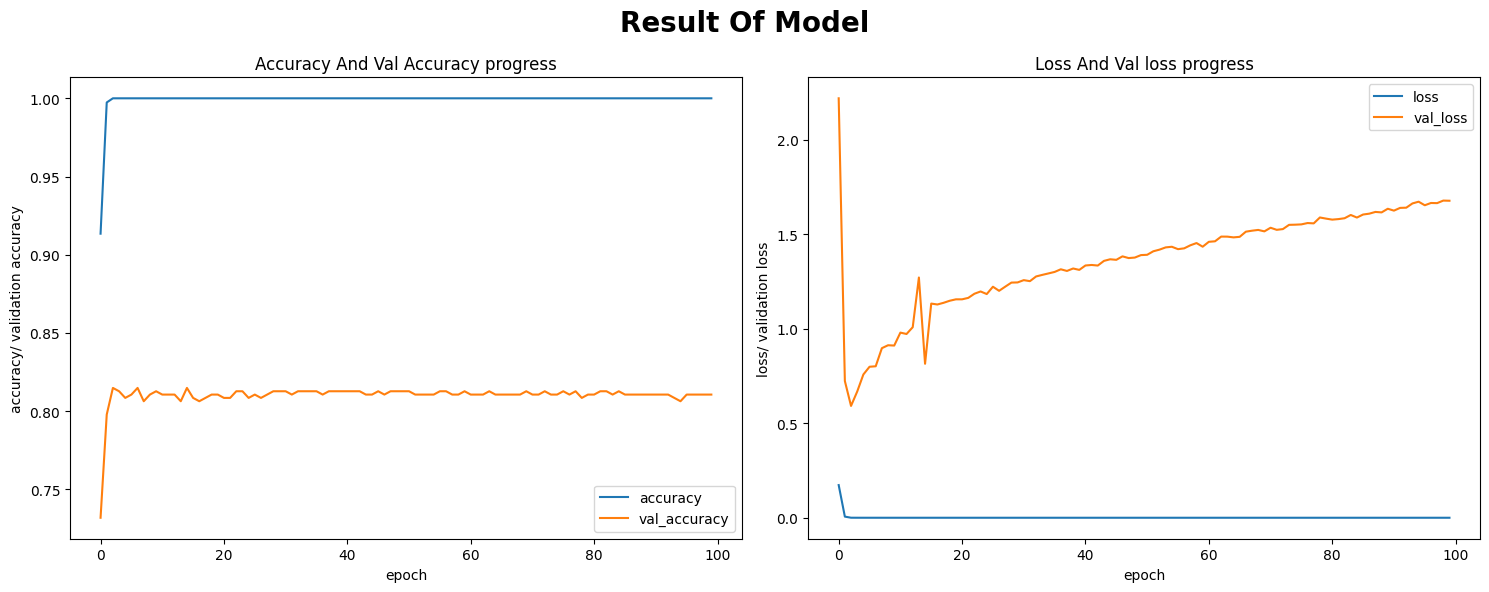

In [ ]:
visualize_result = Visualize_Result(history_1.history['accuracy'],history_1.history['val_accuracy'], history_1.history['loss'], history_1.history['val_loss'])

### ResNet50

Evaluamos una predicción

In [ ]:
#EVALUACIÓN DEL MODELO

loss_value , accuracy = modelRes_sin_aum.evaluate(valid_data)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

#print(modelVGG16_sinAum.predict(test_data))

Visualizamos las gŕaficas.

In [ ]:
visualize_result_resnet50 = Visualize_Result(history.history['accuracy'],history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

### **Resultados**

# Evaluación de los modelos de Machine learning 📊

De forma directa, calculamos el accuracy de entenamiento y validación de los algoritmos clasicos, al no ser tener la misma naturaleza que las CNN's, solo podemos calcular la precisión de forma general y no por iteración

### SVM (Máquina de soporte vectorial)

In [ ]:
# Evaluar rendimiento
svm_acc_train = accuracy_score(y_train, svm_pred_train)
svm_acc_valid = accuracy_score(y_valid, svm_pred_valid)

print("Accuracy - Entrenamiento")
print(svm_acc_train)
print("Accuracy - validación")
print(svm_acc_valid)

Accuracy - Entrenamiento
1.0
Accuracy - validación
0.8085106382978723


## *Decision tree*

In [ ]:
# Evaluar rendimiento
dt_acc_train = accuracy_score(y_train, dt_pred_train)
dt_acc_valid = accuracy_score(y_valid, dt_pred_valid)

print("Accuracy - Entrenamiento")
print(dt_acc_train)
print("Accuracy - validación")
print(dt_acc_valid)

Accuracy - Entrenamiento
1.0
Accuracy - validación
0.6297872340425532
